In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import pygalmesh
import fenics as fe
import torch

import sys
sys.path.append('..')
import project

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv004
--------------------------------------------------------------------------


<IPython.core.display.Javascript object>


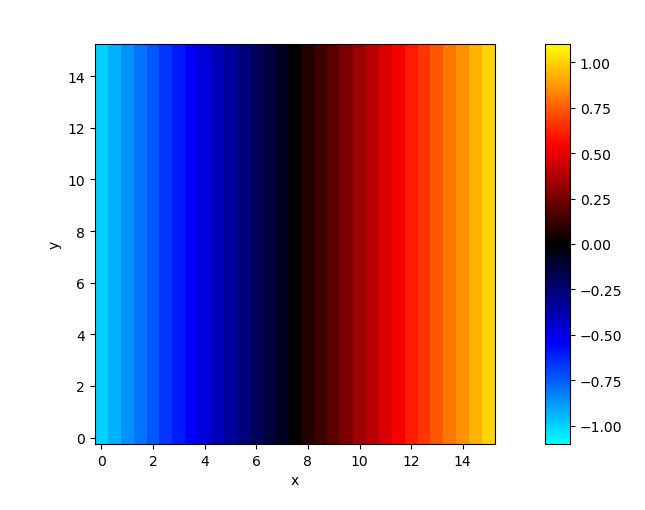

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (0.5, 1), (1.0, 2), (1.5, 3), (2.0, …

In [3]:
%autoreload

# create a test array

shape = (31, 31, 31)
resolution = (0.5, 0.5, 0.5)

disp_x = np.linspace(-1, 1, shape[0])
disp_y = np.linspace(-1, 1, shape[1])
disp_z = np.linspace(-1, 1, shape[2])

disp = xr.DataArray(
    data=np.stack(np.meshgrid(disp_x, disp_y, disp_z, indexing='ij'), axis=-1),
    dims=['x', 'y', 'z', 'component'],
    coords={
        'x': np.arange(shape[0]) * resolution[0], 
        'y': np.arange(shape[1]) * resolution[1],
        'z': np.arange(shape[2]) * resolution[2],
        'component': ['x', 'y', 'z']
    }
)

project.visual.XArrayViewer(disp, x='x', y='y')

<IPython.core.display.Javascript object>


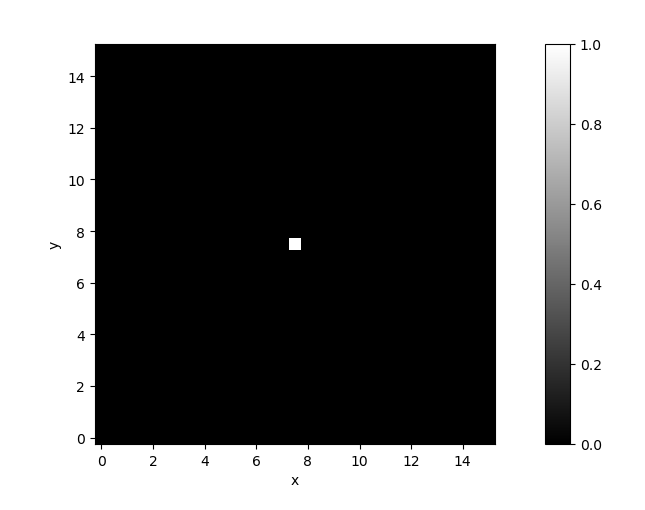

interactive(children=(SelectionSlider(description='z', options=((0.0, 0), (0.5, 1), (1.0, 2), (1.5, 3), (2.0, …

In [4]:
mask = ((disp**2).sum('component') <= 1).astype(np.uint8)
mask.name = 'mask'

project.visual.XArrayViewer(mask)

In [48]:
mesh_radius = 2.0

mesh = pygalmesh.generate_from_array(
    mask.values, voxel_size=resolution, max_cell_circumradius=mesh_radius, odt=True
)

vertices = mesh.points
facets = mesh.cells[0].data
tetras = mesh.cells[1].data

angles = project.meshing.compute_angles_to_interior(vertices, facets, tetras)

vertices.shape, facets.shape, tetras.shape

((233, 3), (588, 3), (884, 4))

<IPython.core.display.Javascript object>


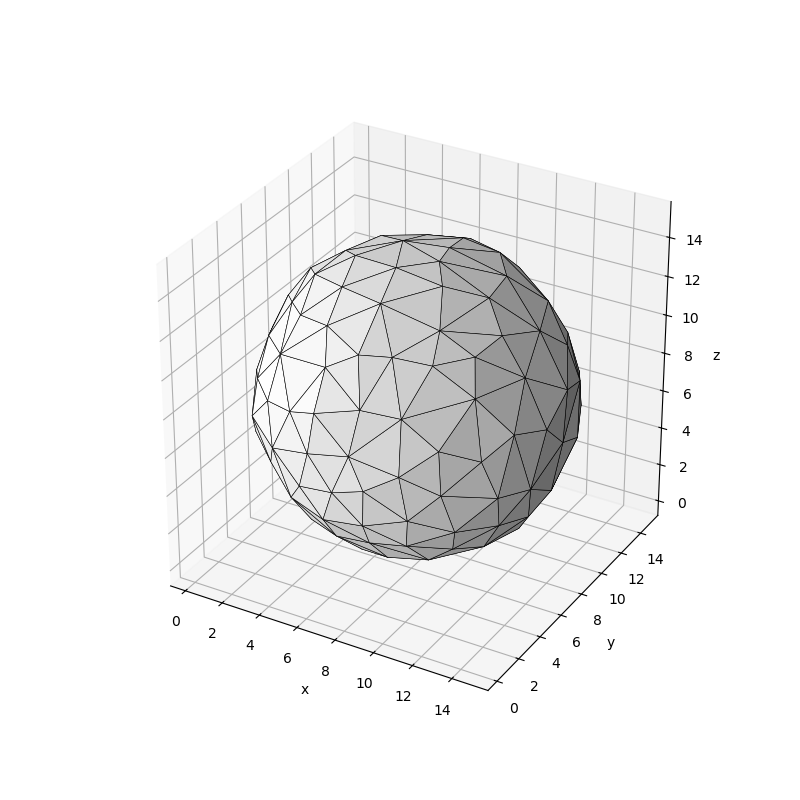

In [49]:
# view surface mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    facets[angles > 0],
    facecolors='white',
    edgecolors='black',
    shade=True,
    alpha=1.0,
    linewidth=0.4,
    figsize=(8,8)
)
#ax.grid(False)
#ax.xaxis.set_pane_color((1,1,1,0))
#ax.yaxis.set_pane_color((1,1,1,0))
#ax.zaxis.set_pane_color((1,1,1,0))
#ax.set_axis_off()

In [55]:
import meshio
from mpi4py import MPI

def convert_to_fe_mesh(points, cells):
    '''
    Convert from meshio to fenics mesh.
    '''
    mesh_file = 'temp.xdmf'
    meshio.write_points_cells(mesh_file, points, [(cells.type, cells.data)])
    fe_mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, mesh_file) as f:
        f.read(fe_mesh)
    return fe_mesh

fe_mesh = convert_to_fe_mesh(mesh.points, mesh.cells[1])

In [56]:
V = fe.FunctionSpace(fe_mesh, 'P', 1)
f = fe.Function(V)
f.vector().get_local().shape

(233,)

In [67]:
def interpolate_image(image, points, radius=1, resolution=1.0, sigma=1.0):
    X, Y, Z, C = image.shape
    N, D = points.shape
    
    if isinstance(radius, int):
        radius = [radius] * D
    
    zeros = torch.zeros(D)
    shape = torch.as_tensor([X, Y, Z])
    resolution = torch.as_tensor(resolution) 
    
    x_offsets = torch.arange(-radius[0], radius[0]) + 1
    y_offsets = torch.arange(-radius[1], radius[1]) + 1
    z_offsets = torch.arange(-radius[2], radius[2]) + 1
    
    offsets = torch.meshgrid(x_offsets, y_offsets, z_offsets)
    offsets = torch.stack(offsets, dim=-1).reshape(-1, D)
    
    interpolated_values = torch.zeros(N, C)

    for i, point in enumerate(points):
        nearest_voxel = (point / resolution).floor().long()
        
        neighbor_voxels = nearest_voxel.unsqueeze(0) + offsets
        neighbor_voxels = neighbor_voxels.clamp(min=zeros, max=shape-1).long()
        
        neighbor_values = image[
            neighbor_voxels[:,0],
            neighbor_voxels[:,1],
            neighbor_voxels[:,2], :
        ]
        
        neighbor_points = neighbor_voxels * resolution.unsqueeze(0)
        distance = torch.norm(neighbor_points - point.unsqueeze(0), dim=1)
        
        #weights = torch.exp(-(distance**2) / (2*sigma**2))
        weights = torch.clamp(1 - torch.abs(distance / (2*sigma)), 0)
        weighted_sum = (weights.unsqueeze(1) * neighbor_values).sum(dim=0) 

        interpolated_values[i] = weighted_sum / weights.sum()
        
    return interpolated_values

interpolate_image(
    image=torch.arange(27).reshape(3,3,3,1),
    points=torch.tensor([[0,0,0],[1,1,1]]),
    radius=1
)

tensor([[ 4.5142],
        [17.5142]])

In [68]:
%%time
import torch
import torch.nn.functional as F

# functions for converting between image-like arrays 
#   and vectors of coefficients for a linear FEM basis

def image_to_dofs(image, resolution, V, radius, sigma):
    '''
    Args:
        image: (n_x, n_y, n_z, n_c) torch.Tensor
        V: fenics.FunctionSpace
            defined on (mesh_size, 3) coordinates
    Returns:
        dofs: (batch_size, mesh_size, n_channels) torch.Tensor
    '''
    if V.num_sub_spaces() == 0:
        image = image.unsqueeze(-1)

    n_x, n_y, n_z, n_c = image.shape
    
    dof_coords = V.tabulate_dof_coordinates()
    if V.num_sub_spaces() > 0:
        dof_coords = dof_coords[::V.num_sub_spaces(),:]
    
    mesh_size, n_dims = dof_coords.shape

    dof_coords = torch.as_tensor(dof_coords, dtype=image.dtype, device=image.device)

    dofs = interpolate_image(
        image=image,
        points=dof_coords,
        resolution=resolution,
        radius=radius,
        sigma=sigma,
    ).double()

    if V.num_sub_spaces() > 0:
        return dofs.view(mesh_size, n_c)
    else:
        return dofs.view(mesh_size)

u_tensor = torch.as_tensor(disp.values)
u_tensor.requires_grad = True

u_func_space = fe.VectorFunctionSpace(fe_mesh, 'P', 1)
u_func_dofs = image_to_dofs(u_tensor, resolution, u_func_space, radius=5, sigma=mesh_radius/2)

L = u_func_dofs.sum()
L.backward()

u_func_dofs.shape

CPU times: user 146 ms, sys: 113 ms, total: 259 ms
Wall time: 115 ms


torch.Size([233, 3])

In [69]:
%%time
import torch_fenics

def dofs_to_image(dofs, V, image_shape, resolution):
    '''
    Args:
        dofs: (mesh_size, n_c) torch.Tensor
        V: fenics.FunctionSpace
            defined on (mesh_size, 3) coordinates
        image_shape: (int, int, int) tuple
    Returns:
        image: (n_x, n_y, n_z, n_c) torch.Tensor
    '''
    if V.num_sub_spaces() > 0:
        mesh_size, n_c = dofs.shape
    else:
        mesh_size, = dofs.shape
        n_c = 1

    n_x, n_y, n_z = image_shape

    x = np.arange(n_x) * resolution[0]
    y = np.arange(n_y) * resolution[1]
    z = np.arange(n_z) * resolution[2]

    grid = np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1)
    print(image_shape, grid.shape)

    func = torch_fenics.numpy_fenics.numpy_to_fenics(
        dofs.detach().cpu().numpy(), fe.Function(V)
    )
    func.set_allow_extrapolation(True)

    image = np.zeros((n_x, n_y, n_z, n_c))

    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                func.eval(image[i,j,k], grid[i,j,k])

    if V.num_sub_spaces() == 0:
        return image.squeeze(-1)
    else:
        return image

u_interp = dofs_to_image(u_func_dofs, u_func_space, shape, resolution)
u_interp.shape

(31, 31, 31) (31, 31, 31, 3)
CPU times: user 280 ms, sys: 862 µs, total: 281 ms
Wall time: 280 ms


(31, 31, 31, 3)

<IPython.core.display.Javascript object>


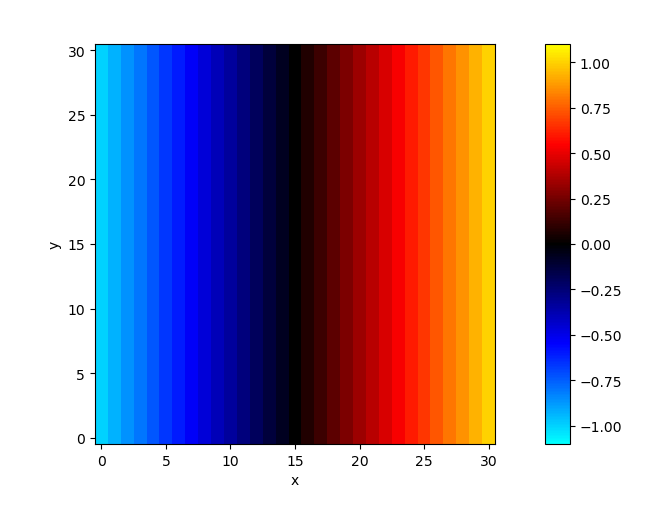

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

<IPython.core.display.Javascript object>


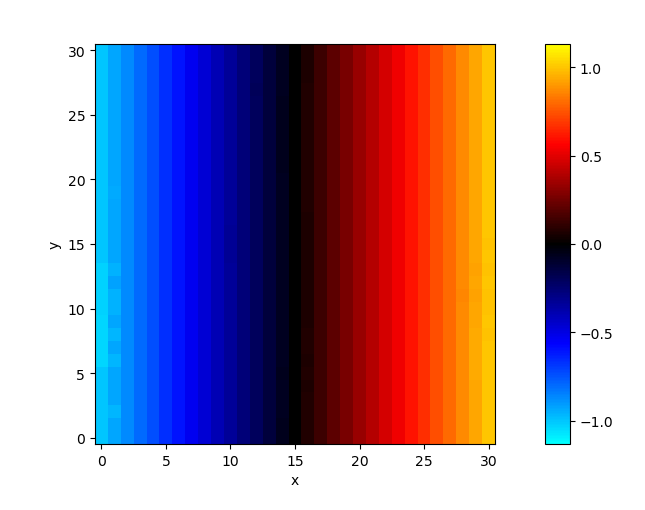

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

<IPython.core.display.Javascript object>


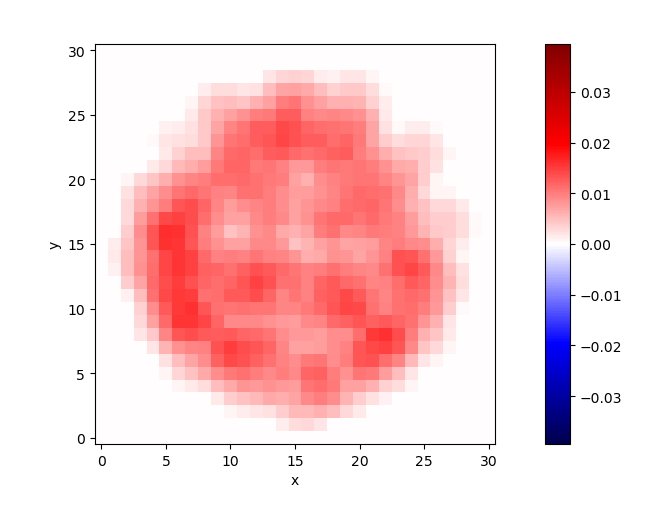

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [70]:
def as_xarray(a, dims=None, coords=None, name=None):
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()
    if dims is None:
        dims = [f'dim{i}' for i in range(a.ndim)]
    if coords is None:
        coords = {d: np.arange(a.shape[i]) for i, d in enumerate(dims)}
    return xr.DataArray(a, dims=dims, coords=coords, name=name)


project.visual.view(as_xarray(u_tensor, dims=['x', 'y', 'z', 'c']))
project.visual.view(as_xarray(u_interp, dims=['x', 'y', 'z', 'c']))
project.visual.view(as_xarray(u_tensor.grad, dims=['x', 'y', 'z', 'c']), cmap='seismic')

In [71]:
L = u_func_dofs.sum()